In [1]:
print(f"""
        Élève         : Vinicius Nascimento
        Num Étudiant  : 00A01916
        Date          : 06 avril 2025
        Classe        : Introduction a Securite des Intelligence Artificielle
        École         : ENSICAEN
        Formation     : CyIA Informatique 2eme année
""")


        Élève         : Vinicius Nascimento
        Num Étudiant  : 00A01916
        Date          : 06 avril 2025
        Classe        : Introduction a Securite des Intelligence Artificielle
        École         : ENSICAEN
        Formation     : CyIA Informatique 2eme année



# Privacy for Machine Learning - Hands On Session

Examples largely inspired by [Near, Joseph P and Chiké Abuah (2022). “Programming Differential Privacy”](https://programming-dp.com/cover.html) (great book to learn about DP and related Python implementations!)

We will use two datasets:
- `not_anonymised_df`: dataset from census (recensement) which contains direct identifiers such as Name, SSN
- `df_vote`: dataset (public) of voting registrations containing Name, SSN, Date of Birth, Zip

Our aim is to find a way of using the `not_anonymised_df` and extract some information while enforcing user privacy.

We will:
- Dee how **anonymising a dataset by solely removing direct identifiers is not enough to guarantee data privacy**
- Perform a **Linkage Attack** on anonymised dataset
- Make the dataset $K$-anonymous

If you have questions related to the course/hands on session, feel free to ask the questions at benjamin.sykes@unicaen.fr

---

Imports

All these libraries except `io` are not part of the default python librairies
You can download them (preferably in a virtual environment running)

```bash
# create virtual environment
python -m virtualenv myVirtualEnv

# activate virtual environment
source myVirtualEnv/bin/activate

# install the relevant packages
pip install numpy
pip install matplotlib
pip install requests
pip install pandas
```

In [3]:
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests

# 1. Making a dataset private

## 1.1 Starting with the datasets

In [18]:
# Loads the datasets as a pandas dataframe
def download_and_load_datasets():
    r1 = requests.get("https://anandmone.com/privacy_for_ml_dataset.csv")
    r2 = requests.get("https://anandmone.com/dummy_registration.csv")
    not_anonymised_df = pd.read_csv(BytesIO(r1.content))
    np.random.seed(123)
    df_vote = pd.read_csv(BytesIO(r2.content)).sample(frac=1, ignore_index=True)
    return not_anonymised_df, df_vote

not_anonymised_df, df_vote = download_and_load_datasets()

<font color="green"><b>¿Q?:</b> Show the first rows of both datasets</font>

_Tip_: on Linux you can use the `head` command to view the first line of a file. Pandas has a similar method

In [19]:
not_anonymised_df.head()

,Name,DOB,SSN,Zip,Workclass,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age,Capital Gain,Capital Loss
0,Igor Scottesmoor,10/6/1962,347-08-4981,99167,Self-emp-not-inc,Bachelors,13,Never-married,Protective-serv,Not-in-family,White,Male,55,United-States,>50K,61,0,0
1,Aggi Buckner,7/20/2000,881-24-1261,31807,Private,Some-college,10,Never-married,Craft-repair,Not-in-family,Black,Male,28,United-States,<=50K,23,0,0
2,Jannelle Lince,11/19/1985,170-76-5978,15860,Private,HS-grad,9,Never-married,Sales,Own-child,White,Female,40,United-States,<=50K,38,0,0
3,May Pigden,2/6/1956,531-17-9708,14965,Private,1st-4th,2,Married-civ-spouse,Other-service,Husband,White,Male,53,Mexico,<=50K,67,0,0
4,Idaline Snodin,8/20/1955,189-55-8894,17739,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,50,France,>50K,68,0,0


In [20]:
df_vote.head()

,Name,SSN,DOB,Zip
0,Marla Swate,608-07-3181,9/21/1992,77373
1,Blaire Pacey,770-60-9305,5/3/1969,19443
2,Pamella Rosborough,837-77-6790,5/28/1979,15711
3,Karleen Glanester,808-10-0428,2/1/1973,88563
4,Karlene Marder,505-41-1129,5/13/1999,14472


<font color="green"><b>¿Q?:</b> Show all attributes present in the dataset</font>

_Tip_: the attributes correspond to columns in the dataset

In [21]:
not_anonymised_df.columns

Index(['Name', 'DOB', 'SSN', 'Zip', 'Workclass', 'Education', 'Education-Num',
       'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Hours per week', 'Country', 'Target', 'Age', 'Capital Gain',
       'Capital Loss'],
      dtype='object')

In [ ]:
df_vote.columns

Index(['Name', 'SSN', 'DOB', 'Zip'], dtype='object')

<font color="green"><b>¿Q?:</b> Which attributes are direct identifiers/unique identifiers? <b>Create a new dataset which doesn't include the direct identifiers</b>

_Tip_: remove columns/attributes by using the `drop` method

In [22]:
anonymised_df = not_anonymised_df.copy().drop(columns=["Name", "SSN"])
anonymised_df.head()

,DOB,Zip,Workclass,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age,Capital Gain,Capital Loss
0,10/6/1962,99167,Self-emp-not-inc,Bachelors,13,Never-married,Protective-serv,Not-in-family,White,Male,55,United-States,>50K,61,0,0
1,7/20/2000,31807,Private,Some-college,10,Never-married,Craft-repair,Not-in-family,Black,Male,28,United-States,<=50K,23,0,0
2,11/19/1985,15860,Private,HS-grad,9,Never-married,Sales,Own-child,White,Female,40,United-States,<=50K,38,0,0
3,2/6/1956,14965,Private,1st-4th,2,Married-civ-spouse,Other-service,Husband,White,Male,53,Mexico,<=50K,67,0,0
4,8/20/1955,17739,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,50,France,>50K,68,0,0


## 1.1 Linkage attack

Scenario:
- We have access to the `anonymised_df` dataset
- We have access to the `df_vote` dataset which is public
- We want to retrieve informations on our "friend" from the anonymised dataset.

Our friend’s name is Annie Mone, and we know Annies’s date of birth (`DOB`=1/2/1961) and zip code (`Zip`=14000).



<font color="green"><b>¿Q?:</b> Extract rows relevant to Annie Mone in the `df_vote` dataset</b>

_Tip_: `dataframe[condition]` outputs the index of rows satisfying the condition. `dataframe[dataframe[condition]]` extracts the values where condition is met

In [23]:
annies_row = df_vote[df_vote["Name"]=="Annie Mone"]
annies_row = annies_row[annies_row["DOB"]=="1/2/1961"]
annies_row

,Name,SSN,DOB,Zip
2265,Annie Mone,142-23-2417,1/2/1961,14000


<font color="green"><b>¿Q?</b>: Join the databases on Date Of Birth and Zip code. This should be equivalent to the SQL query:</font>


```sql
SELECT *
FROM annies_row AS a
JOIN anonymised_df AS d
ON a.DOB = d.DOB AND a.Zip = d.Zip;
```

_Tip_: `JOIN` in SQL $\iff$ `merge` in Pandas

In [24]:
# solution
query = annies_row.merge(anonymised_df, how='inner', on=['DOB', 'Zip'])
query

,Name,SSN,DOB,Zip,Workclass,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age,Capital Gain,Capital Loss
0,Annie Mone,142-23-2417,1/2/1961,14000,Musician,Masters,13,Married-civ-spouse,Musician,Wife,White,Female,40,France,<=50K,62,0,0


<font color="red">We can now infer Annie's salary from this linkage!!</font>

---
<font color="green"><b>¿Q?</b>: If we only knew zip code, which information could we get?</font>



In [25]:
query=annies_row.merge(anonymised_df, how='inner', on=['Zip'])
query

,Name,SSN,DOB_x,Zip,DOB_y,Workclass,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age,Capital Gain,Capital Loss
0,Annie Mone,142-23-2417,1/2/1961,14000,12/22/1982,Private,7th-8th,4,Married-civ-spouse,Other-service,Husband,White,Male,40,Mexico,<=50K,41,0,0
1,Annie Mone,142-23-2417,1/2/1961,14000,1/2/1961,Musician,Masters,13,Married-civ-spouse,Musician,Wife,White,Female,40,France,<=50K,62,0,0
2,Annie Mone,142-23-2417,1/2/1961,14000,1/5/1978,Private,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,40,United-States,<=50K,45,0,0
3,Annie Mone,142-23-2417,1/2/1961,14000,10/9/1990,Trader,NaN,13,Never-married,Money,Own-child,White,Male,5,France,>50K,30,9882384,0
4,Annie Mone,142-23-2417,1/2/1961,14000,10/9/1999,Producer,Masters,13,Married-civ-spouse,Music Producer,Wife,White,Female,40,France,>50K,20,25900,0


# 1.2 How Many People can we Re-Identify?

<font color="green"><b>¿Q?</b>: How unique is a birthdate? Show how many people share the same exact birthdate</font>

DOB
4/10/1959     1
12/13/1969    1
7/17/1965     1
11/26/1979    1
3/5/1958      1
             ..
12/20/1970    7
6/28/2005     7
7/22/1999     7
2/6/1988      7
10/23/1983    8
Name: count, Length: 17311, dtype: int64


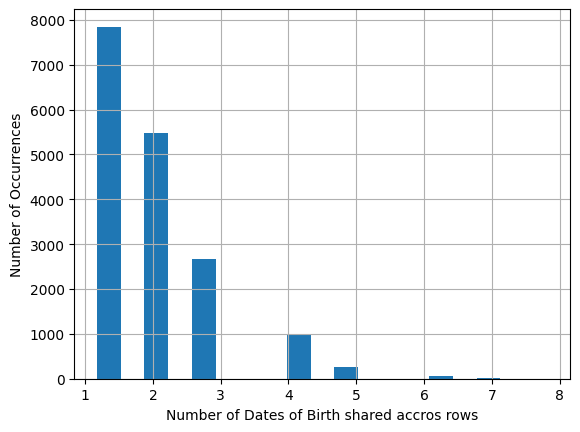

In [26]:
identifiable_birthday = anonymised_df["DOB"].value_counts().sort_values()
identifiable_birthday.hist(rwidth=0.5)
print(identifiable_birthday)

plt.xlabel('Number of Dates of Birth shared accros rows')
plt.ylabel('Number of Occurrences');
plt.show()

<font color="green"><b>¿Q?</b>: How unique is a Zip Code? Show how many people share the same exact Zip code</font>


Zip
35314    1
4716     1
4957     1
39745    1
61095    1
        ..
14000    5
32527    5
69315    5
39163    5
35283    5
Name: count, Length: 27791, dtype: int64


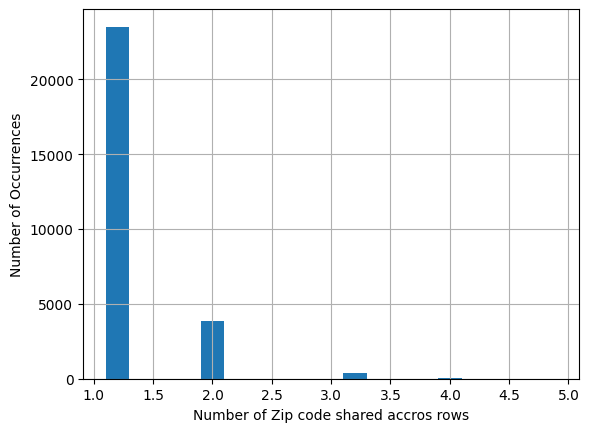

In [27]:
identifiable_zip= anonymised_df["Zip"].value_counts()
identifiable_zip.hist(rwidth=0.5)
print(identifiable_zip.sort_values())

plt.xlabel('Number of Zip code shared accros rows')
plt.ylabel('Number of Occurrences')
plt.show()

<font color="green"><b>¿Q?</b>:
How many people are vulnerable to linkage attacks?


Count the number of unique names when joining the two tables on some attributes you choose</font>

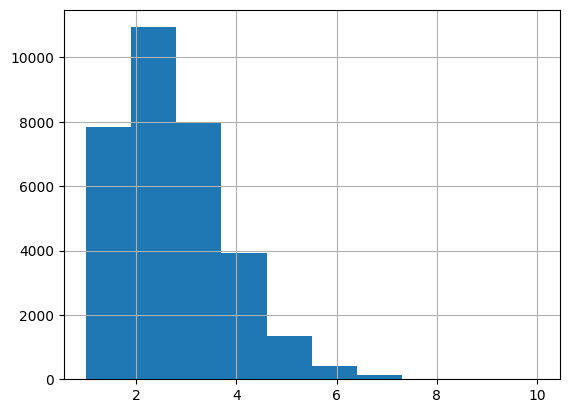

In [28]:
linkage = anonymised_df.merge(df_vote, how='inner', on=['DOB'])
linkage['Name'].value_counts().hist();

Using more information we should re identify more individuals as there should be less conflicts

<font color="green"><b>¿Q?</b>: Join the tables using more than one attribute</font>

_Tip_: you can use "DOB" and "Zip"

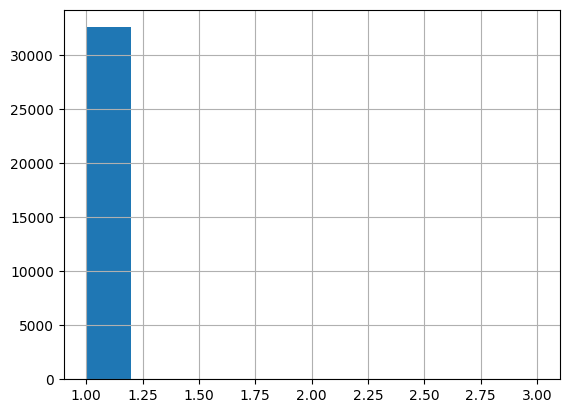

In [29]:
linkage = anonymised_df.merge(df_vote, how='inner', on=['DOB', 'Zip'])
linkage['Name'].value_counts().hist();

💡 In the original paper pointing out linkage attacks (Sweeney, Latanya (2000). “Simple Demographics Often Identify People Uniquely”.), the author shows that **87% of people in the US can be uniquely re-identified by the combination of date of birth, gender, and ZIP code.** 💡

___

# 2. K-anonymity

**K-anonymity definition**:

Formally, a dataset $D$ satisfies $k$-Anonymity for a given $k$ if:  

$$  
\forall r_1 \in D, \quad \exists \text{ at least } k-1 \text{ other rows } r_2, \dots, r_k \in D  
$$  

such that:  

$$  
\Pi_{qi(D)} r_1 = \Pi_{qi(D)} r_2 = \dots = \Pi_{qi(D)} r_k  
$$  

where $r_i$ are rows of the dataset, $qi(D)$ is the quasi-identifiers of $D$, and $\Pi_qi(D)$ is the projection onto these quasi-identifiers  

## 2.1 Verify K-anonymity
<font color="green"><b>¿Q?</b>: Write a function which given a dataframe states if it satisfies K-anonymity</font>

_Tip_:`df.groupby(columns)` groups elements in the dataframe by columns. You can then apply count, mean, or other functions to the aggregated groups


In [30]:
def check_k_anonymity(df, k, quasi_identifiers):
    grouped_counts = df.groupby(quasi_identifiers).size()
    is_k_anonymous = (grouped_counts >= k).all()
    return bool(is_k_anonymous)

Verify you code here. The dataset if $2$-anonymous (it is always $1$-anonymous)

In [31]:
# Example usage:
toy_df = pd.DataFrame({
    "Age": [25, 30, 25, 40, 30, 25],
    "Zip": ["12345", "12345", "67890", "67890", "12345", "67890"],
    "Sex": ["Male", "Male", "Female", "Male", "Female", "Female"]
})

quasi_identifiers = ["Age", "Zip"]
k = 1

print(check_k_anonymity(toy_df, k=k, quasi_identifiers=quasi_identifiers))  # Output: True or False

True


## 2.2 Make the dataset K-anonymous

<font color="green"><b>¿Q?</b>: Release a simplified version of the dataset, only using Zip, Age and Capital Loss which satisfies $2$-anonymity

Verify the new dataset is indeed K-anonymous
</font>


In [40]:
k_anonymous_df = not_anonymised_df[['Zip', 'Age', 'Capital Loss']].copy()

k_anonymous_df['Age'] = (k_anonymous_df['Age'] // 20) * 20
k_anonymous_df['Zip'] = k_anonymous_df['Zip'].astype(str).str[:2] + 'XXX'

violating_groups = k_anonymous_df.groupby(['Age', 'Zip']).size().reset_index(name='count')
violating_groups = violating_groups[violating_groups['count'] < 2]
print(violating_groups)


     Age    Zip  count
310   60   4XXX      1
361   80  53XXX      1


In [41]:
k_anonymous_df = k_anonymous_df.groupby(['Age', 'Zip']).filter(lambda x: len(x) >= 2)

check_k_anonymity(k_anonymous_df,quasi_identifiers=["Age", "Zip"],k=2)

True

**[Vinicius]** : To ensure 2-anonymity, I first generalized the `Age` and `Zip` columns into broader buckets. After doing so, only two unique combinations still violated the requirement. I applied a group filter to remove those rare cases, which allowed the dataset to fully satisfy 2-anonymity without excessive generalization.


---

# 3. Differential Privacy

Remember the following setting from the Introduction to Privacy for Machine Learning Class

- **Dataset** $\mathbf{X}=(x_1,...x_n)$
- **Mechanism** $\mathcal{Y}$-valued $M$ s.t $\forall x, M(x)=\phi(x,U)$ where $\phi$ is deterministic and $U$ a random seed
- **Neighbour datasets** $\mathbf{X}, \mathbf{X'}$ such that $d(\mathbf{X},\mathbf{X'})=1$ $\iff$ they match all records but one


A mechanism $M$ being $\mathcal{Y}$-valued is $\epsilon-\text{DP}$ for some $\epsilon \geq 0$ $\iff$ $\forall \mathbf{X},\mathbf{X'} / d(\mathbf{X},\mathbf{X'})=1$ and $\forall \mathcal{S} \subset \mathcal{Y}$  we have

$$
\boxed{\mathbb{P}(M(\mathbf{X})\in S)\leq e^\epsilon.\mathbb{P}(M(\mathbf{X'})\in S)}
$$


**In practice**:

In practise to make a query differentially private, we can **add some noise to the original output of the query**:

Let us consider a deterministic function $f : x \mapsto f(x)$

Sensitivity of $f$ is $D=\max(f)-\min(f)$

To make the output of f $\epsilon$-DP, we add some Laplacian noise of mean=0 and scale=$\frac{D}{\epsilon}$



Here is a code snipet illustrating an $\epsilon$-DP query:


```python
import numpy as np
def differentially_private_output(query_output, epsilon, sensitivity):
    scale = sensitivity/epsilon
    return query_output  + np.random.laplace(loc=0, scale=scale, size=n)
```

## 3.1 Differential Privacy on a simple query

Differential Privacy is often used to make **the output of a query private**. This can be the case for exemple for couting queries or mean.

<font color="green"><b>¿Q?</b>: Make the following query Differentialy Private</font>

```sql
SELECT COUNT(*)
FROM not_anonymised_df
WHERE Target = '<=50K'
AND Name = Annie Mone;
```

In [53]:
epsilon = 1
sensitivity = 1

def differentially_private_output(query_output, epsilon, sensitivity):
    scale = sensitivity/epsilon
    return query_output  + np.random.laplace(loc=0, scale=scale, size=1)

annies_row = not_anonymised_df[(not_anonymised_df["Target"]=='<=50K') & (not_anonymised_df["Name"]=='Annie Mone')]

real_count = annies_row.shape[0]

print(f"The real count is {real_count}")

dp_count = differentially_private_output(real_count, epsilon, sensitivity)

print(f"The DP count is {dp_count}")

The real count is 1
The DP count is [3.14680601]


<font color="green"><b>¿Q?</b>: What would happen if an attacker could access to the output of this query an infinite number of times?</font>

**[Vinicius] :** If an attacker could access the output of this query an infinite number of times, they could average the results and cancel out the noise added by the differential privacy mechanism. Over time, the noisy counts would converge to the true value (in this case, 1), effectively defeating the privacy protection. This is why differential privacy requires limiting the number of times a query can be made — or tracking a privacy budget — to ensure that privacy guarantees are not lost due to repeated access.

## 3.2 Logistic regression with differential privacy

We have at hand a dataset composed of:
- Features $\mathbf{X}=(\mathbf{x_1}, ..., \mathbf{x_N})$ where each point $x_i \in \mathbb{R}^d$ , that is $\mathbf{x_i}=(x_i^1, ..., x_i^d)$
- Labels $\mathbf{y} = (y_1, ..., y_N)$ and each $y_i \in \{-1,1\}$

(That is for each entry in the database ($\forall x_i \in \mathbf{X}$), there is a binary label corresponding to this entry)

In this section we want to create a classifier that predicts label $y$ given $x$ as an input. We use the simple yet illustrative approach of **logistic regression**
Which aims to learn a linear classier $f_\theta$ parametrised by $\theta=(w_1,...,w_d)$ and the bias $b$ and is defined as:

$$
f_\theta(x)=\sigma\left(\sum_{i=1}^d w_i.x^i+b\right)
$$

Where $\sigma :x \mapsto \frac{1}{1+\exp(-x)}$ is the sigmoid function.
The model finally represents:
$$
\boxed{f_\theta(x)=\mathbb{P}_\theta(y=1|\mathbf{x})}
$$

The weights are learned on the training set such that when the dot product between the weights and the input $\mathbf{x}$ is computed, it is of the same sign as the label $y$ we are trying to predict

**For the sake of simplicity, we will be imposing bias $b=0$**

This is what the sigmoid function looks like

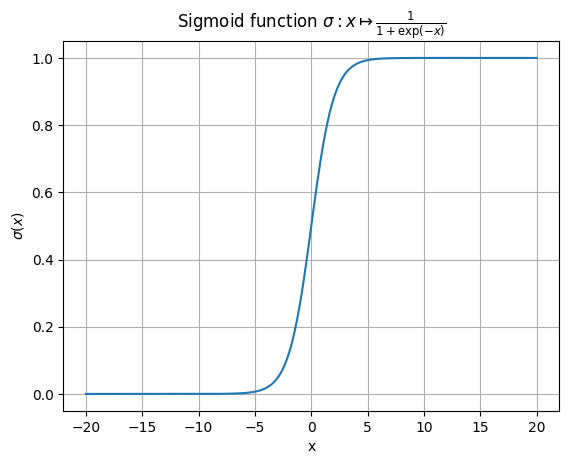

In [54]:
sigmoid = lambda x: 1/(1+np.exp(-x))

x_values = np.linspace(-20,20,1000)
y_values = sigmoid(x_values)

plt.plot(x_values, y_values)
plt.xlabel("x")
plt.ylabel(r"$\sigma(x)$")
plt.title(r"Sigmoid function $\sigma :x \mapsto \frac{1}{1+\exp(-x)}$")
plt.grid()

In [55]:
def get_x_y_numpy():
    def get_one_npy(url):
        r = requests.get(url)
        data = np.load(BytesIO(r.content))
        return data
    x_dataset = get_one_npy('https://github.com/uvm-plaid/programming-dp/raw/master/notebooks/adult_processed_x.npy')
    y_dataset = get_one_npy('https://github.com/uvm-plaid/programming-dp/raw/master/notebooks/adult_processed_y.npy')
    y_dataset[y_dataset==-1]=0
    return x_dataset, y_dataset


X, y = get_x_y_numpy()

<font color="green"><b>¿Q?</b>: What is the size of the dataset, what is the dimension of the target $y$?</font>


In [56]:
print(X.size+y.size)
print(X.shape)
print(y.shape)

4748100
(45220, 104)
(45220,)


Split the dataset into 80% trainset and 20% testset

In [57]:
split_index = int(0.8 * X.shape[0])

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(36176, 104)
(9044, 104)
(36176,)
(9044,)


Evaluate the accuracy of this model on the test set using the `model.predict` method

In [58]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)*100

print(f"Test set accuracy: {accuracy:.4f}%")

Test set accuracy: 84.4870%


### Simple gradient descent

We will now train our logistic regression ourselves!

To do so, we first need to define a **loss function** which we want to minimise.\
We will be using binary crossentropy loss
$$
\textit{loss}(f_\theta(\mathbb{x_i}),y_i)=-y_i \log(f_\theta(\mathbb{x_i})) - (1-y_i) \log(1-f_\theta(\mathbb{x_i}))$$

$$:
- if $y_i=0$, $\textit{loss}(f_\theta(\mathbb{x_i}),y_i)=-\log(f_\theta(\mathbb{x_i}))$: reducing the loss indeed makes the output class prediction close to 0; $\mathbb{P}_\theta(y=1|\mathbb{x}) \to 0 \implies \mathbb{P}_\theta(y=0|\mathbb{x})\to1$
- if $y_i=1$, $\textit{loss}(f_\theta(\mathbb{x_i}),y_i)=-\log(1-f_\theta(\mathbb{x_i}))$: reducing the loss indeed makes the output class prediction close to 1; ($\mathbb{P}_\theta(y=1|\mathbb{x}) \to 1$)


In [59]:
def initialise_params():
    theta = np.random.randn(X.shape[1])
    return theta
theta = initialise_params()

def loss_function(theta, xi, yi):
    f_theta = xi.dot(theta)
    pred_proba = sigmoid(f_theta)
    loss_value = - (yi * np.log(pred_proba) + (1 - yi) * np.log(1 - pred_proba))
    return loss_value

def output_model(theta,xi):
    output = sigmoid(xi.dot(theta))
    return output

def custom_predict(theta, xi):
    output = output_model(theta, xi)
    return (output >(1/2)).astype(int)

def custom_accuracy(theta, X_test, y_test):
    return np.sum(custom_predict(theta, X_test) == y_test)/X_test.shape[0]

def gradient(theta, xi, yi):
    grad = xi * ((output_model(theta, xi)) -yi)
    return grad

<font color="green"><b>¿Q?</b>: Implement gradient descent</font>

In [60]:
def gradient_descent(iterations, lr, X_train, y_train):
    theta = initialise_params()

    for it in range(iterations):
        gradients = np.zeros_like(theta)

        for xi, yi in zip(X_train, y_train):
            gradients += gradient(theta, xi, yi)

        average_gradient = gradients / X_train.shape[0]
        theta = theta - lr * average_gradient

    return theta

theta = gradient_descent(100,lr=0.1, X_train=X_train, y_train=y_train)

custom_accuracy(theta, X_test,y_test)

np.float64(0.7320875718708536)

We will now learn our parameters using **gradient descent**. Here is the learning process:
1. Pass batches of the learning data through the model: $f_\theta(\mathbb{X})$
2. Compute the loss associated to these predictions: $\textit{loss}(f_\theta(\mathbb{x_i}),y_i)=-f_\theta(\mathbb{x_i})y_i$
3. As we want to minimise this loss, compute the gradient of this loss with respect to the parameters of the model: $\nabla_\theta \textit{loss}(f_\theta(\mathbb{x_i}),y_i)$ (the gradient of our model is given below)
4. Make the parameters of the model go one step in the direction of dimishing loss: $\theta_{t+1}=\theta_t-\alpha \nabla_\theta \textit{loss}(f_\theta(\mathbb{x_i}),y_i)$ where $\alpha$ is called the "learning rate"

<font color="green"><b>¿Q?</b>: Check that the loss indead is decreasing on one single gradient step:</font>


In [61]:
theta = initialise_params()
theta

lr = 1e-1

print(f"{loss_function(theta,X[0],y[0])=}")
for it in range(10):
# theta=np.zeros_like(theta)

    theta-=lr*gradient(theta,X[0],y[0])

    print(f"{loss_function(theta,X[0],y[0])=}")


loss_function(theta,X[0],y[0])=np.float64(3.763789052188776)
loss_function(theta,X[0],y[0])=np.float64(2.955568092133568)
loss_function(theta,X[0],y[0])=np.float64(2.205432135094703)
loss_function(theta,X[0],y[0])=np.float64(1.560807332866453)
loss_function(theta,X[0],y[0])=np.float64(1.0682116998609728)
loss_function(theta,X[0],y[0])=np.float64(0.7360023937930967)
loss_function(theta,X[0],y[0])=np.float64(0.5279859080186228)
loss_function(theta,X[0],y[0])=np.float64(0.3981983959628074)
loss_function(theta,X[0],y[0])=np.float64(0.31407700248344206)
loss_function(theta,X[0],y[0])=np.float64(0.25681072546482736)
loss_function(theta,X[0],y[0])=np.float64(0.2159845317923114)


## 3.4 Differentially private gradient descent

<font color="green"><b>¿Q?</b>: **Implement a differentialy private gradient descent**</font>



1. Pass batches of the learning data through the model: $f_\theta(\mathbb{X})$
2. Compute the loss associated to these predictions: $\textit{loss}(f_\theta(\mathbb{x_i}),y_i)=-f_\theta(\mathbb{x_i})y_i$
3. Compute the gradient of this loss with respect to the parameters of the model: $\nabla_\theta \textit{loss}(f_\theta(\mathbb{x_i}),y_i)$
4. Clip the gradient to avoid samples to effect the gradient in to significative way
5. Add some Laplacian noise to the gradient, scaled to the $\frac{\text{sensitivity}}{\epsilon}$
4. Make the parameters of the model go one step in the direction of dimishing loss: $\theta_{t+1}=\theta_t-\alpha (\nabla_\theta \textit{loss}(f_\theta(\mathbb{x_i}),y_i) + \text{noise})$ where $\alpha$ is called the "learning rate"

<font color="green"><b>¿Q?</b>: Implement clip function that returns the initial value $z$ if $\Vert z \Vert_2<\text{threshold}$ and a scaled version of norm=threshold if $\Vert z \Vert_2\geq\text{threshold}$</font>

In [62]:
def clip_gradient(grad, threshold):
    norm = np.linalg.norm(grad)

    if norm > threshold:
        return grad * (threshold / norm)
    else:
        return grad

def epsilon_dp_gradient_descent(iterations, lr, epsilon, threshold, X_train, y_train):
    theta = initialise_params()

    for it in range(iterations):
        grads = []

        for xi, yi in zip(X_train, y_train):
            grad_i = gradient(theta, xi, yi)
            clipped = clip_gradient(grad_i, threshold)
            grads.append(clipped)

        average_gradient = np.mean(grads, axis=0)

        sensitivity = threshold / X_train.shape[0]
        noise = np.random.laplace(loc=0, scale=sensitivity/epsilon, size=theta.shape)

        noisy_gradient = average_gradient + noise

        theta = theta - lr * noisy_gradient

    return theta

<font color="green"><b>¿Q?</b>: Run your DP gradient descent algorithm</font>

In [63]:
iterations = 30
threshold = 1
epsilon=1

dp_theta = epsilon_dp_gradient_descent(iterations, lr, epsilon, threshold, X_train, y_train)

custom_accuracy(dp_theta, X_test,y_test)

np.float64(0.6687306501547987)

<font color="green"><b>¿Q?</b>: What are the effect both on the accuracy of the model and on its privacy of using larger privacy budget $\epsilon$?</font>


In [64]:
...

Ellipsis

**[Vinicius] :** When we increase the privacy budget ε, the noise added to the gradients becomes smaller. This usually improves the model's accuracy, as the updates are closer to the true gradients. However, it also means that the privacy guarantee becomes weaker, since the mechanism becomes more sensitive to individual data points.

In summary: larger ε improves accuracy but reduces privacy, while smaller ε improves privacy but may harm the model's performance.